# topo-descriptors

A python library to compute DEM-based topographical descriptors.

## Usage

Let's install `topo-descriptors` with few additional packages that will help us
to run a simple example:

In [3]:
%pip install topo-descriptors elevation rasterio matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


[elevation](https://github.com/bopen/elevation) is an python library that provides
an easy access to global elevation data. Here we are going to clip the SRTM 30m
DEM around the Basodino region in southern Switzerland, around 46.4N 8.5E:

In [1]:
!eio clip -o Basodino-30m-DEM.tif --bounds 8.2 46.30 8.6 46.55

curl -s -o spool/N46/N46E008.hgt.gz.temp https://s3.amazonaws.com/elevation-tiles-prod/skadi/N46/N46E008.hgt.gz && mv spool/N46/N46E008.hgt.gz.temp spool/N46/N46E008.hgt.gz
gunzip spool/N46/N46E008.hgt.gz 2>/dev/null || touch spool/N46/N46E008.hgt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 spool/N46/N46E008.hgt cache/N46/N46E008.tif 2>/dev/null || touch cache/N46/N46E008.tif
rm spool/N46/N46E008.hgt
gdalbuildvrt -q -overwrite SRTM1.vrt cache/N46/N46E008.tif
cp SRTM1.vrt SRTM1.3867a8e4146f411ebf2edc35bd3beb1f.vrt
gdal_translate -q -co TILED=YES -co COMPRESS=DEFLATE -co ZLEVEL=9 -co PREDICTOR=2 -projwin 8.2 46.55 8.6 46.3 SRTM1.3867a8e4146f411ebf2edc35bd3beb1f.vrt /Users/daniele/src/topo-descriptors/Basodino-30m-DEM.tif
rm -f SRTM1.3867a8e4146f411ebf2edc35bd3beb1f.vrt


Now in python we can use the xarray interface to rasterio to easily import our
`Basodino-30m-DEM.tif` file:

/var/folders/v1/d7jjg8d52fl77y27qbv75bw80000gp/T/ipykernel_85468/3852191236.py:3: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  dem = xr.open_rasterio("Basodino-30m-DEM.tif")


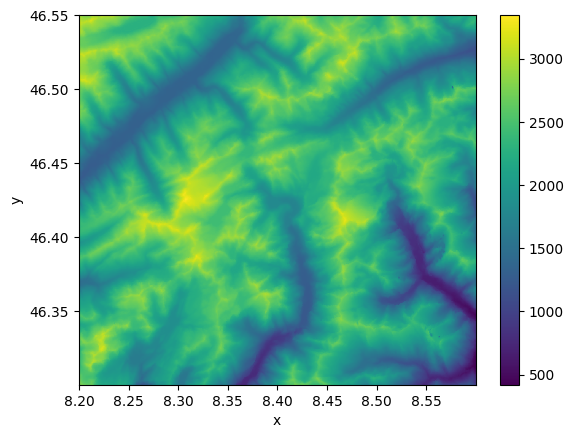

In [4]:
import xarray as xr

dem = xr.open_rasterio("Basodino-30m-DEM.tif")
dem = dem.isel(band=0, drop=True)
dem.plot()

With the DEM data imported as a xarray DataArray, we can use topo-descriptors to
compute two established topographical descriptors: the topographical position index
(TPI) and the Sx. The TPI describes the elevation of a given point relatively
to its neighbourhood, here defined on a 500 meter scale:

Reprojecting coordinates from WGS84 to UTM to obtain units of meters


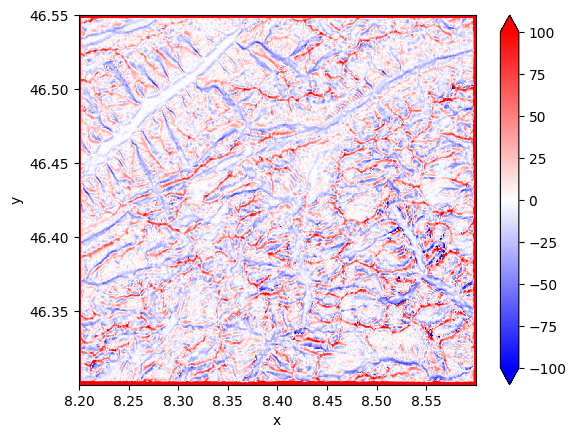

In [6]:
from topo_descriptors import topo, helpers

scale_meters = 500
scale_pixel, __ = helpers.scale_to_pixel(scale_meters, dem)
topo.tpi(dem, scale_pixel).plot(vmin=-100, vmax=100, cmap="bwr")

The Sx is used to describe the horizon in a given direction and spatial scale.
In the example below we compute the Sx for a 0° azimuth (i.e., looking North)
and a radius of 500 meters.

Reprojecting coordinates from WGS84 to UTM to obtain units of meters
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


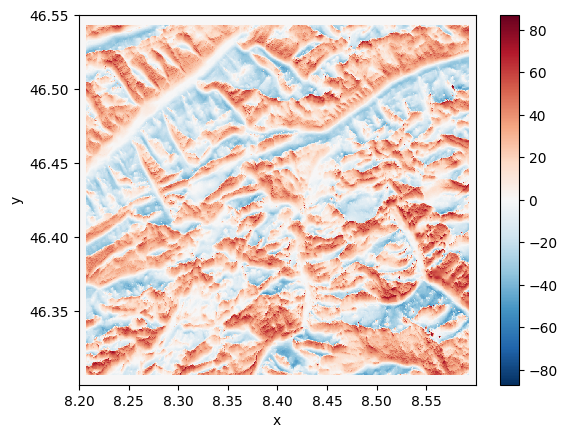

In [7]:
sx_500m = topo.sx(dem, azimuth=0, radius=500)
xr.DataArray(sx_500m, coords=dem.coords).plot.imshow()

Other topographical descriptors are available, such as slope, aspect, derivatives,
and more.